# Setting up SFINCS to work with the National Water Model (Redelivery)
### Author: Tadd Bindas

In the below notebook, we will outline how SFINCS is to be set up to run on a prototype catchment (Coffeyville, KS) using NWM 3.0 inputs for discharge and output boundary levels

This notebook's outputs are meant to be fed into `02_post_process.ipynb` sequentially

### Imports and references to s3 bucket data

We're going to set up all of the imports to our required data and the data catalogs HydroMT uses to read data from cloud storage

In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils


Below we're going to set up the references to DEM files which live in the cloud, and our SFINCS model object

In [2]:
data_catalog_path = Path.cwd() / "../data/SFINCS/data_catalogs"
sfincs_model_path = Path.cwd() / "../data/SFINCS/ngwpc_data"
lynker_spatial_lib = str(data_catalog_path / "lynker_spatial/gridded_data.yaml")
sf = SfincsModel(data_libs=[lynker_spatial_lib], root=str(sfincs_model_path), mode="w+")


Model dir already exists and files might be overwritten: /app/data/SFINCS/ngwpc_data/gis.


In [3]:
import sys

current_dir = Path.cwd()
src_path = current_dir.parents[0]
sys.path.append(src_path.__str__())

from src.rise.utils import hydrofabric  # noqa: E402


We're going to be using the Hydrofabric v2.2 for this model run, however, the .gpkg file in the conus_nextgen file lives is too large for GitHub. Thus, we're going to be pulling from pre-sliced subsets. The code to generate those slices if they don't exist (*as long as you have the conus_nextgen.gpkg file* downloaded from [here](https://www.lynker-spatial.com/data?path=hydrofabric%2Fv2.2%2Fconus%2F))

In [4]:
data_path = Path.cwd() / "../data/NWM"
start_node = "nex-2185393"
end_node = "nex-2185398" 

if (data_path / "domain_nexus.gpkg").exists():
    domain_nexus = gpd.read_file(data_path / "domain_nexus.gpkg")
    domain_flowlines = gpd.read_file(data_path / "domain_flowlines.gpkg")
    domain_divides = gpd.read_file(data_path / "domain_divides.gpkg")
    downstream_nexus = gpd.read_file(data_path / "downstream_nexus.gpkg")
else:
    file_path = Path.cwd() / "../data/NWM/conus_nextgen.gpkg"
    
    flowlines = hydrofabric.get_layer(file_path, layer="flowpaths")
    nexus = hydrofabric.get_layer(file_path, layer="nexus")
    divides = hydrofabric.get_layer(file_path, layer="divides")
    network = hydrofabric.get_layer(file_path, layer="network")
    flowpath_attributes = hydrofabric.get_layer(file_path, layer="flowpath-attributes")
    
    G = hydrofabric.get_hydrofabric_vpu_graph(nexus, flowlines)
    
    start_node = "nex-2185393"
    end_node = "nex-2185398" 
    path = nx.shortest_path(G, start_node, end_node)
    
    mask_flowlines = flowlines["id"].isin(path) | flowlines["toid"].isin(path) & (flowlines["toid"] != end_node)
    mask_nexus = nexus["id"].isin(path) | nexus["toid"].isin(path) & (nexus["id"] != end_node)
    mask_divides = divides["id"].isin(path) | divides["toid"].isin(path)
    mask_attributes = flowpath_attributes["id"].isin(path)
    
    _subset_nexus = nexus[mask_nexus]
    _subset_flowlines = flowlines[mask_flowlines]
    downstream_nexus = nexus[nexus["id"] == end_node]
    
    domain_nexus = nexus[
        nexus["toid"].isin(_subset_flowlines["id"]) | 
        (nexus["id"].isin(path) | nexus["toid"].isin(path) & (nexus["id"] != end_node))
    ]
    domain_flowlines = flowlines[flowlines["toid"].isin(domain_nexus["id"])]
    domain_divides = divides[mask_divides]
    
    _subset_nexus.to_file(data_path / "domain_nexus.gpkg", driver='GPKG')
    _subset_flowlines.to_file(data_path / "domain_flowlines.gpkg", driver='GPKG')
    _subset_divides.to_file(data_path / "domain_divides.gpkg", driver='GPKG')
    downstream_nexus.to_file(data_path / "downstream_nexus.gpkg", driver='GPKG')


Now, let's plot the domain information and the flowlines which feed into it

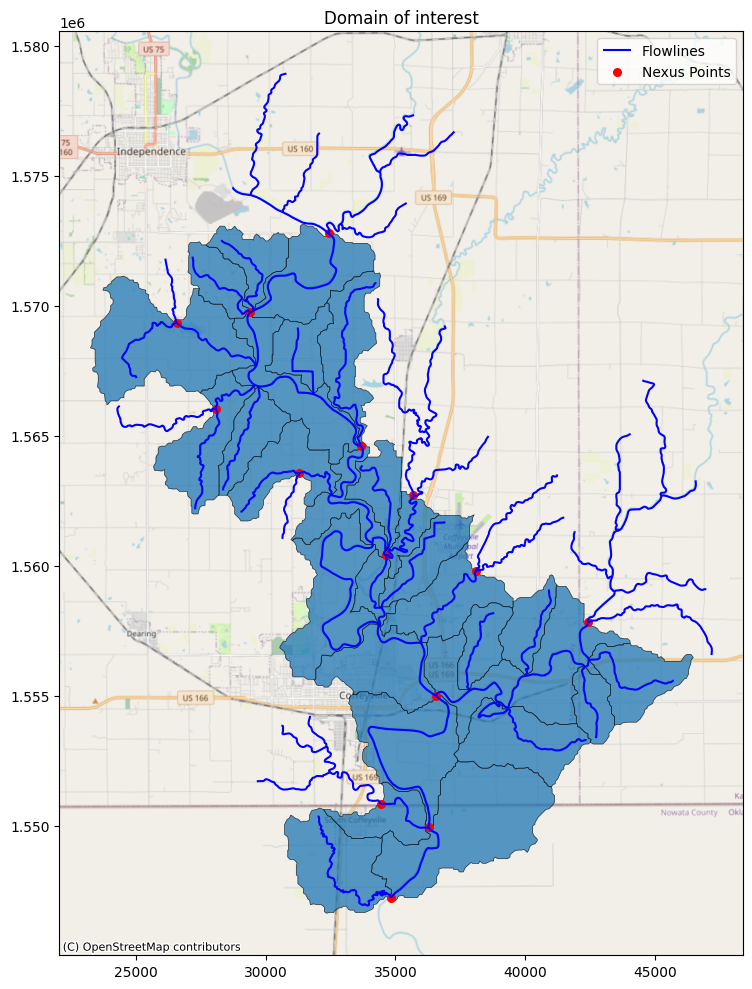

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
domain_divides.plot(ax=ax, edgecolor="k", linewidth=0.5, alpha=0.75,)
domain_flowlines.plot(ax=ax, color='blue', label='Flowlines')
domain_nexus.plot(ax=ax, color='red', markersize=30, label='Nexus Points')
try:
    cx.add_basemap(ax, crs=domain_divides.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Couldn't add basemap: {e}")
ax.legend()
plt.title("Domain of interest")
plt.tight_layout()
plt.show()

### Setting up the grid and the model inputs

Below, we're going to set up the following inputs:
- The grid
- Elevation
- Boundary mask
- Inputs
- Boundary forcings

We're using the divides as our region/boundary box below

In [6]:
sf.setup_grid_from_region(
    region = {'geom': domain_divides},
    res= 50,
    rotated=True,
    crs=domain_divides.crs  # NAD83 / Conus Albers HARDCODED TODO figure out making this cleaner
)
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)


{'mmax': 348, 'nmax': 536, 'dx': 50, 'dy': 50, 'x0': 32075.0, 'y0': 1545718.0, 'rotation': 21.972, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


Below, we're going to reference the Lynker Spatial DEM as our base elevation

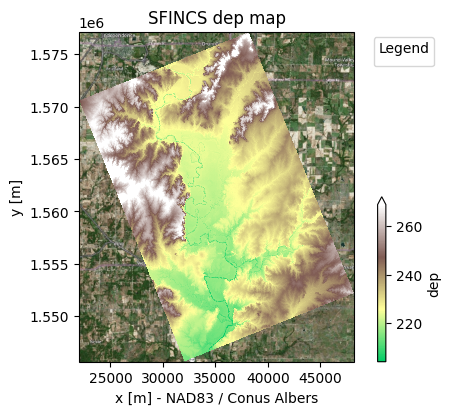

In [7]:
datasets_dep = [{"elevtn": "USGS_seamless_13", "zmin": 0.001}]
dep = sf.setup_dep(datasets_dep=datasets_dep)
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)


Next, we're going to set our mask and downstream water level point for SFINCS

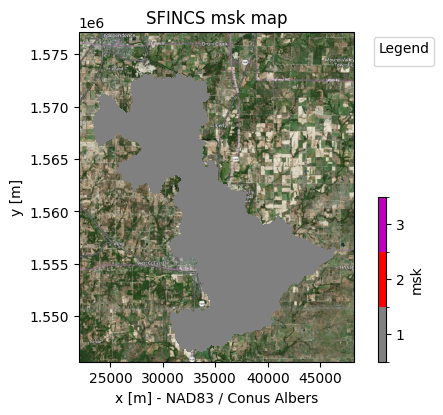

In [8]:
sf.setup_mask_active(include_mask=domain_divides,reset_mask=True)
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)


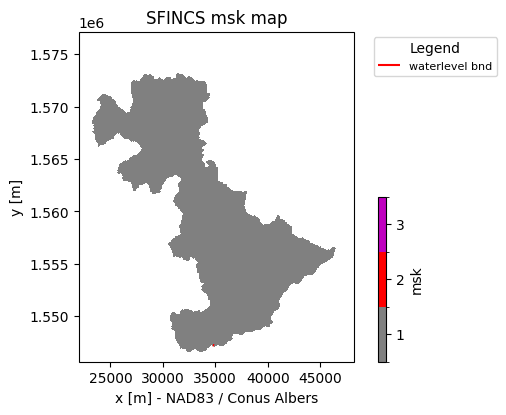

In [9]:
sf.setup_mask_bounds(btype="waterlevel", include_mask=downstream_nexus, reset_bounds=True)
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, zoomlevel=12)


Now that we have our mask, we can use the domain flowlines with a buffer of 10m to ensure intersections

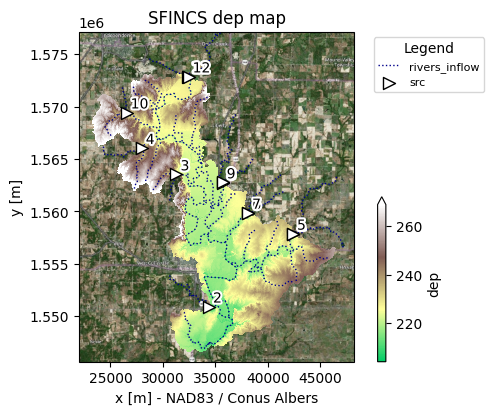

In [10]:
sf.setup_river_inflow(
    rivers=domain_flowlines, 
    buffer=10,
    keep_rivers_geom=True
)
# print(sf.config)
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)


Next, we're going to open the domain network dataframe (which is already precalculated and in this git repo) and determine all of the  NHD comids we need to pull from the NWM retrospective

In [11]:
network_path = Path.cwd() / "../data/NWM/domain_network.csv"
sfincs_points = sf.forcing['dis'].vector.to_gdf()
joined_flowlines = gpd.sjoin_nearest(sfincs_points, domain_flowlines, how='left')

if network_path.exists():
    domain_network = pd.read_csv(network_path)
else:
    domain_network = network[network["id"].isin(joined_flowlines["id"])]
all_comids = list(set([x for _, group in domain_network.groupby("id") 
              for x in group["hf_id"].values.astype(int).tolist()]))
output_dir = Path.cwd() / "../data/NWM/nwm30_retrospective"


Since the retrospective takes too long to query on demand, and teehr has many dependencies, we have preprocessed this parquet file and the below code is how we got the parquet file

In [12]:
# Commented out as this takes too long to run. Parquet file has already been processed

# !pip install teehr==0.4.6
# from datetime import datetime
# import teehr.fetching.nwm.retrospective_points as nwm_retro

# start_date = datetime(2019, 5, 20)
# end_date = datetime(2019, 6, 3)

# nwm_retro.nwm_retro_to_parquet(
#     nwm_version="nwm30",
#     variable_name="streamflow",
#     start_date=start_date,
#     end_date=end_date,
#     location_ids=all_comids,
#     output_parquet_dir=output_dir
# )


Let's read the parquet file and group the COMIDS by ID. Then we'll put them into an array which matches the index of the SFINCS inputs  

In [13]:
flow_data = pd.read_parquet(output_dir / "20190520_20190603.parquet")
flow_data[['nwm_version', 'location_id']] = flow_data['location_id'].str.split('-', expand=True)
time_range = flow_data.value_time.unique()

In [14]:
flows_arr = np.zeros((len(time_range), sf.forcing['dis'].shape[1]))
for idx, row in joined_flowlines.iterrows():
    _id = row["id"]
    inflow_segments = domain_network[domain_network["id"] == _id]
    group_ids = inflow_segments["hf_id"].values.astype(int)
    subset_flow_data = flow_data[flow_data["location_id"].astype(int).isin(group_ids)]
    summed_flows = subset_flow_data.groupby("value_time")["value"].sum().reset_index()
    flows_arr[:, idx-1] = summed_flows["value"].values * 0.02834

Next, we're setting up the sfincs config, reference time with start and stop, then zsini (initial conditions streamflow elevation). The reason we have to set up boundary elevation conditions is because the reference datum is at sea level, so SFINCS needs to know the elevation of the water_level with respect to sealevel or else the FIM will perform poorly

In [15]:
sf.setup_config(
    **{
        "tref": "20190520 000000",
        "tstart": "20190520 000000",
        "tstop": "20190603 000000",
        "zsini": 206.0  # Hardcoded to match domain of interest values
    }
)
index = [1]  # NOTE that the index should start at one
pnts = gpd.points_from_xy(
    [downstream_nexus.geometry.x.values[0]], # TODO CHANGE NAME TO DOWNSTREAM
    [downstream_nexus.geometry.y.values[0]],
)
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=downstream_nexus.crs)
display(bnd)
time = [
    pd.Timestamp(utils.parse_datetime(sf.config["tstart"])),
    pd.Timestamp(utils.parse_datetime(sf.config["tstop"]))
]
bzs = [[206.0], [206.0]] # hard coding the outflow boundary starting value to around the elevation
bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
display(bzspd)
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)

,geometry
1,POINT (34816.421 1547233.167)


,1
2019-05-20,206.0
2019-06-03,206.0


We're going to plot our inputs below. The LARGE hydrograph point is #11, not (#0 matplotlib ran out of colors)

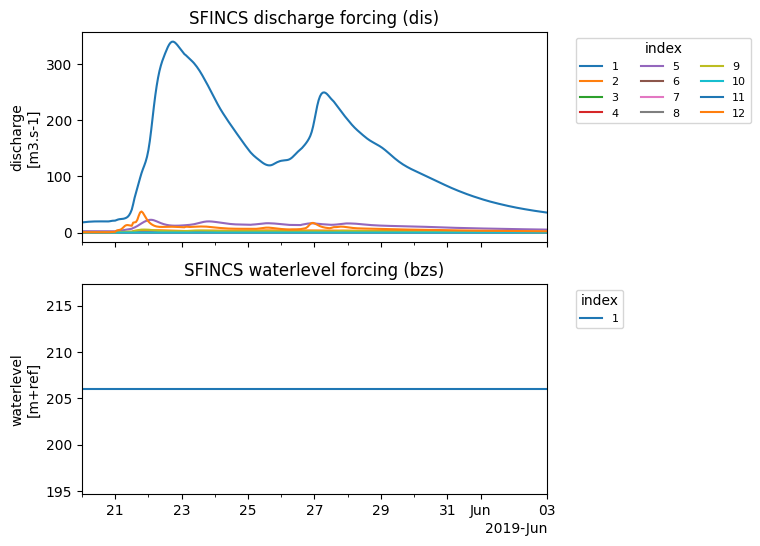

In [16]:
index = sf.forcing["dis"].index  # TODO check the units of retrospective
dispd = pd.DataFrame(index=time_range, columns=index, data=flows_arr)
sf.setup_discharge_forcing(timeseries=dispd)
_ = sf.plot_forcing(fn_out="forcing.png")

### Conclusion

Now we are going to plot the final basemap, and write our sfincs conditions to disk

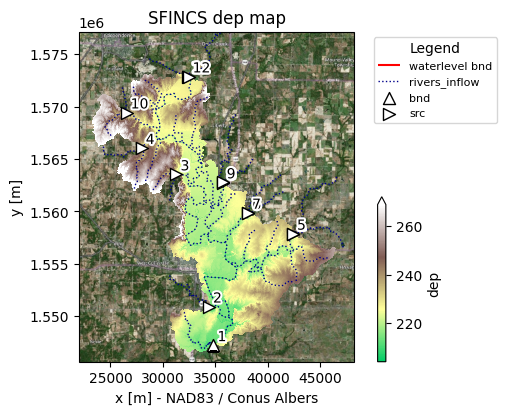

In [17]:
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)

In [18]:
sf.write()
dir_list = os.listdir(sf.root)
print(dir_list)


['sfincs_map.nc', 'sfincs.src', 'sfincs.dis', 'gis', 'sfincs.bnd', 'hydromt_data.yml', 'figs', 'sfincs.inp', 'hydromt.log', 'wgwpc_data', 'sfincs.dep', 'sfincs.bzs', 'sfincs.msk', 'sfincs.ind']


Now, we are going to run `sudo ./run_sfincs.sh` from the terminal to run SFINCS!